In [10]:
import os

import torch
from torch import nn
import tqdm
from matplotlib import pyplot as plt

import monotonicnetworks as lmn
plt.style.use('res/mpl-config')

In [2]:
# |W|_1,inf constraint two ways
linear_by_norming = lmn.direct_norm(nn.Linear(10, 10), kind='one-inf')
linear_native = lmn.LipschitzLinear(10, 10, kind='one-inf')

In [3]:
# Specify monotonicity constraints w.r.t each input
# First output is monotonically increasing, second has no constraint 
# and third is monotonically decreasing w.r.t the first input
# The second input only has the second output as a monotonically increasing constraint
linear = lmn.MonotonicLayer(2, 3, monotonic_constraints=[[1, 0, -1], [0, 1, 0]])

In [4]:
# GroupSort weight-constrained NNs are universal approximators
# of lipschitz functions
lip_nn = nn.Sequential(
    lmn.LipschitzLinear(2, 32, kind="one-inf"),
    lmn.GroupSort(2),
    lmn.LipschitzLinear(32, 2, kind="inf")
)

### Toy Regression

Fit the following function: $$f(x) = log(x) + \epsilon(x)$$ where $\epsilon$ is a gaussian noise term whose variances increases linearly with x. Despite the noise, we will assume that this function is monotonic. For example, a trigger algorithm to discriminate between signal and background events, rarer events might be singal and thus we want a function which is monotonic w.r.t "rareness."

To compare, we will fit an unconstrained model and monotonic Lipschitz model

In [28]:
width = 128

class UnconstrainedModel(nn.Module):
    def __init__(self):
        super(UnconstrainedModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(1, width),
            nn.Tanh(),
            nn.Linear(width, width),
            nn.Tanh(),
            nn.Linear(width, 1)
        )
    
    def forward(self, x):
        return self.model(x)

# Lipschitz-1 network
class MonotonicModel(nn.Module):
    def __init__(self):
        super(MonotonicModel, self).__init__()
        self.model = nn.Sequential(
            lmn.LipschitzLinear(1, width, kind="one-inf"),
            lmn.GroupSort(2),
            lmn.LipschitzLinear(width, width, kind="inf"),
            lmn.GroupSort(2),
            lmn.LipschitzLinear(width, width, kind="inf"),
            lmn.GroupSort(2),
            lmn.LipschitzLinear(width, 1, kind="inf")
        )

    def forward(self, x):
        return self.model(x)

In [29]:
EPOCHS = 3000
N = 30 # Number of points
loss_fn = nn.MSELoss()

path = os.path.join(os.getcwd(), 'monotonic')
os.makedirs(path, exist_ok=True)

In [32]:
up = False
interp = False
y_list_fname = f"y_list_monotonicExample-Up{up}-Interp{interp}.pt"
y_robust_list_fname = f"y_robust_list_monotonicExample-Up{up}-Interp{interp}.pt"

# simple toy data
def gen_data(interp=False, up=False):
    seed = 20 if up else 18
    torch.manual_seed(seed)
    max_range = 3
    if interp == False:
        x_train = torch.linspace(1, max_range, N).view(-1, 1)
    else:
        x_train = torch.linspace(1, max_range, N // 2).view(-1, 1)
        x_train = torch.cat([x_train, torch.linspace(1.5, 2, N//2).view(-1, 1) * max_range], dim=0)
    true_model = lambda x: torch.log(x)
    y_train = true_model(x_train)
    y_error = torch.linspace(0.01, 0.3, N).view(-1, 1)
    noise = torch.randn(N).view(-1, 1) * y_error
    y_train -= noise

    x_linspace = torch.linspace(1, max_range * 2, 2 * N).view(-1, 1)
    y_linspace = true_model(x_linspace)
    return x_train, y_train, x_linspace, y_linspace, y_error

x_train, y_train, x_linspace, y_linspace, y_error = gen_data(interp=interp, up=up)

In [31]:
y_list = []
y_robust_list = []
torch.manual_seed(0)
num_trials = 2

y_file = os.path.join(path, y_list_fname)
y_robust_file = os.path.join(path, y_robust_list_fname)
if os.path.exists(y_file) and os.path.exists(y_robust_file):
    y_list = torch.load(y_file)
    y_robust_list = torch.load(y_robust_file)
else:
    for i in range(num_trials):
        model = UnconstrainedModel()
        monotonic_model = lmn.MonotonicWrapper(MonotonicModel(), 1)
        optim = torch.optim.Adam([{"params" : model.parameters()}, {"params" : monotonic_model.parameters()}], lr=1e-2)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, EPOCHS)

        # Train both models at the same time
        pbar = tqdm.trange(EPOCHS)
        for i in pbar:
            y = model(x_train)
            y_robust = monotonic_model(x_train)
            loss = loss_fn(y, y_train)
            loss_robust = loss_fn(y_robust, y_train)
            loss_robust.backward()
            loss.backward()
            optim.step()
            scheduler.step()
            optim.zero_grad()
            pbar.set_description(
                f"epoch: {i} loss: {loss.item():.4f}, loss_robust: {loss_robust.item():.4f}")
            # Plot results
        with torch.inference_mode():
            model.eval()
            y = model(x_linspace)
            y_robust = monotonic_model(x_linspace)
            y_list.append(y)
            y_robust_list.append(y_robust)
        # save lists
    torch.save(y_list, os.path.join(path, y_list_fname))
    torch.save(y_robust_list, os.path.join(path, y_robust_list_fname))

epoch: 2999 loss: 0.0105, loss_robust: 0.0111: 100%|██████████| 3000/3000 [00:06<00:00, 490.78it/s]


In [33]:
up = False
interp = False
y_list_fname = f"y_list_monotonicExample-Up{up}-Interp{interp}.pt"
y_robust_list_fname = f"y_robust_list_monotonicExample-Up{up}-Interp{interp}.pt"
y_list = torch.load(os.path.join(path, y_list_fname))
y_robust_list = torch.load(os.path.join(path, y_robust_list_fname))
x_train, y_train, x_linspace, y_linspace, y_error = gen_data(interp=interp, up=up)

/var/folders/2c/vcj1sjcd5_1_1x98xt0k4dlw0000gn/T/ipykernel_38036/2627504825.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  y_list = torch.load(os.path.join(path, y_list

Saved /Users/afterless/projects/notebooks/src/monotonic/monotonic_dependence_unobserved_UpFalse_InterpFalse.png


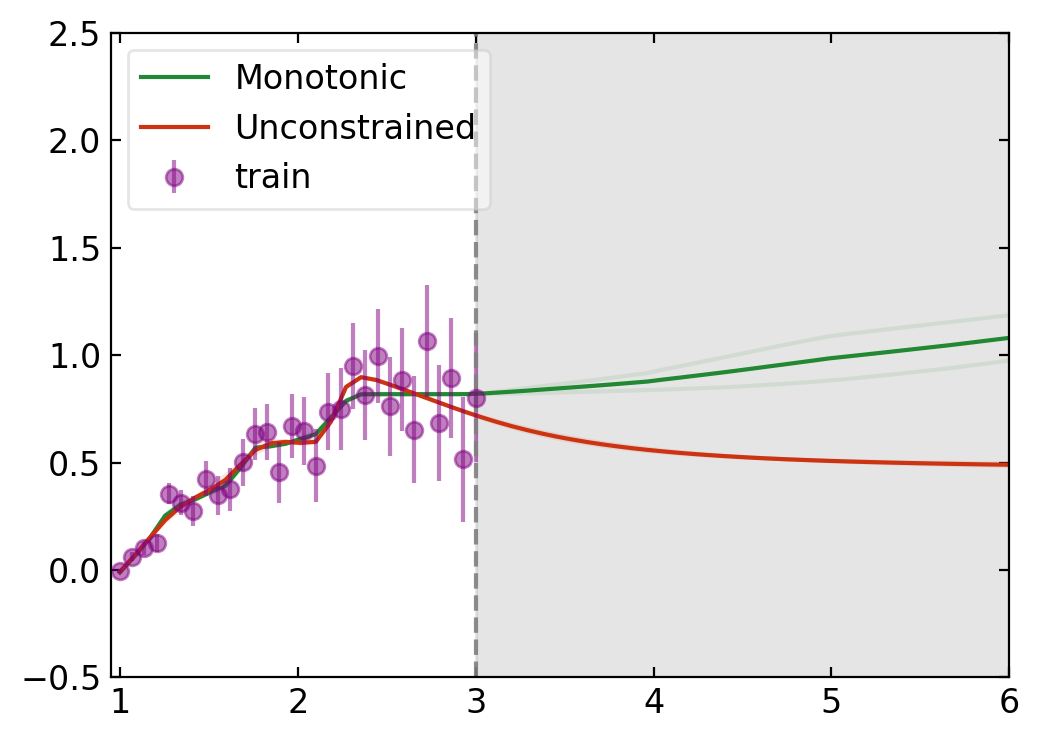

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3.5), dpi=200)
for y, y_robust in zip(y_list, y_robust_list):
    ax.plot(x_linspace.numpy(), y_robust.numpy(), color='C1', alpha=0.1)
    ax.plot(x_linspace.numpy(), y.numpy(), color='C2', alpha=0.1)
# plot mean
ax.plot(x_linspace.numpy(), torch.hstack(y_robust_list).mean(1).numpy(), color='C1', label='Monotonic')
ax.plot(x_linspace.numpy(), torch.hstack(y_list).mean(1).numpy(), color='C2', label='Unconstrained')

plt.errorbar(x_train.numpy().flatten(), y_train.numpy().flatten(), 
    yerr=y_error.numpy().flatten(), fmt='o', c='purple', label='train', alpha=0.5)
plt.legend(loc='upper left')
ax.set_ylim(-0.5, 2.5)
ax.set_xlim(1-0.05,6)
if interp:
    ax.axvline(3, c='gray', linestyle='--', alpha=0.9)
    ax.axvline(4.5, c='gray', linestyle='--', alpha=0.9)
    ax.fill_betweenx([-0.5, 2.5], 3, 4.5, color='gray', alpha=0.2)
else:
    ax.axvline(3, c='gray', linestyle='--', alpha=0.9)
    ax.fill_betweenx([-2, 3], 3, 6, color='gray', alpha=0.2)
figname = f"monotonic_dependence_unobserved_Up{up}_Interp{interp}.png"
figname = os.path.join(path, figname)
plt.tight_layout(pad=0)
plt.savefig(figname)
print("Saved", figname)
plt.show()

Now show the same sort of dataset but with one noise datapoint, where the Lipschitz continuous function is more robust against outliers than an unconstrained network, as the gradient w.r.t the input is bounded between -1 and 1, and hence robust against adversarial attacks/data corruption.

In [35]:
def gen_data2(N):
    torch.manual_seed(4)
    x_train = torch.linspace(-3, 3, N).view(-1, 1)

    y_train_error = torch.ones(N).view(-1, 1) * 0.01
    y_train_error[N // 2] = 1
    y_train = torch.sin(x_train) + torch.randn(N).view(-1, 1) * y_train_error

    # PLOT DATA
    x_linspace = torch.linspace(-3, 3, 2 * N).view(-1, 1)
    y_linspace = torch.sin(x_linspace)
    return x_train, y_train, x_linspace, y_linspace, y_train_error
x_train, y_train, x_linspace, y_linspace, y_error = gen_data2(31)

In [36]:
torch.manual_seed(0)
loss_func = torch.nn.L1Loss()
y_file = os.path.join(path, "y_list_robustExample.pt")
y_robust_file = os.path.join(path, "y_robust_list_robustExample.pt")
if os.path.exists(y_file) and os.path.exists(y_robust_file):
    y_list = torch.load(y_file)
    y_robust_list = torch.load(y_robust_file)
else:
    y_list = []
    y_robust_list = []
    num_trials = 2
    for _ in range(num_trials):
        pbar = tqdm.trange(EPOCHS)
        model = UnconstrainedModel()
        robust_model = MonotonicModel()
        optim = torch.optim.Adam([{"params" : model.parameters()}, {"params" : robust_model.parameters()}], lr=1e-1)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, EPOCHS)
        for i in pbar:
            y = model(x_train)
            y_robust = robust_model(x_train)
            loss = torch.mean(loss_func(y, y_train))
            loss_robust = loss_func(y_robust, y_train)
            loss_robust.backward()
            loss.backward()
            optim.step()
            scheduler.step()
            optim.zero_grad()
            pbar.set_description(
                f"epoch: {i} loss: {loss.item():.4f}, loss_robust: {loss_robust.item():.4f}")

        with torch.no_grad():
            y = model(x_linspace)
            y_robust = robust_model(x_linspace)
            y_list.append(y)
            y_robust_list.append(y_robust)
    # save lists
    torch.save(y_list, y_file)
    torch.save(y_robust_list, y_robust_file)

epoch: 2999 loss: 0.1929, loss_robust: 0.0440: 100%|██████████| 3000/3000 [00:06<00:00, 439.92it/s]


Saved monotonic/robust_against_noisy_outlier.png


/var/folders/2c/vcj1sjcd5_1_1x98xt0k4dlw0000gn/T/ipykernel_38036/3387984032.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  y_list = torch.load(y_file)
/var/folders/2c/v

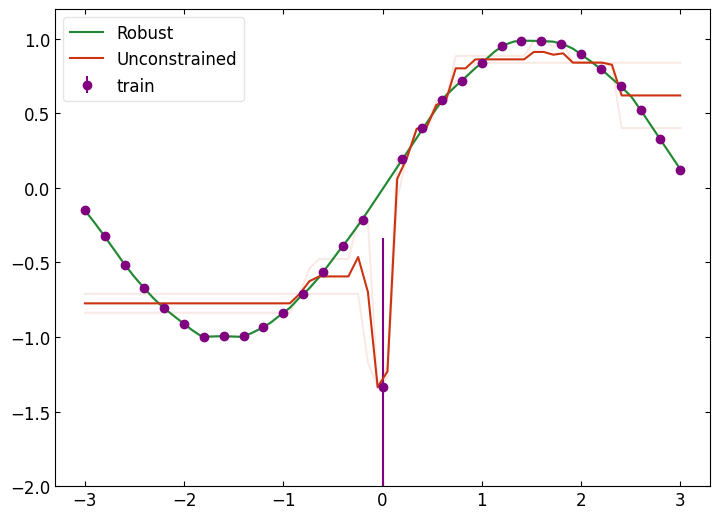

In [37]:
# load lists
y_list = torch.load(y_file)
y_robust_list = torch.load(y_robust_file)

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
plt.errorbar(x_train.numpy().flatten(), y_train.numpy().flatten(), yerr=y_error.numpy().flatten(), fmt='o', c='purple', label='train')
for y, y_robust in zip(y_list, y_robust_list):
    ax.plot(x_linspace.numpy(), y_robust.numpy(), color='C1', alpha=0.1)
    ax.plot(x_linspace.numpy(), y.numpy(), color='C2', alpha=0.1)
# plot mean
ax.plot(x_linspace.numpy(), torch.hstack(y_robust_list).mean(1).numpy(), color='C1', label='Robust')
ax.plot(x_linspace.numpy(), torch.hstack(y_list).mean(1).numpy(), color='C2', label='Unconstrained')

plt.legend()
figname = "monotonic/robust_against_noisy_outlier.png"
plt.ylim(-2, 1.2)
plt.tight_layout(pad=0)
plt.savefig(figname)
print("Saved", figname)
plt.show()